# DANN 领域迁移实验

从mnist数据集迁移到mnist_m数据集， mnist_m数据集由mnist数据集和BSDS500数据集部分像素块混合而成。

DANN 论文链接：https://arxiv.org/abs/1505.07818

论文解释：https://zhuanlan.zhihu.com/p/122571123

mnist_m数据链接：https://pan.baidu.com/s/1I5QE1NxJcvlFYWC8YHa4Bg 
提取码：ywz4
在该笔记同级目录下创建dataset文件夹，将下载的压缩包放入并解压。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler,Dataset,DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import shutil
import os

## 工具函数

In [2]:
def adjust_learning_rate(optimizer,epoch):
    lr=0.001*0.1**(epoch//10)
    for param_group in optimizer.param_groups:
        param_group['lr']=lr
    return lr

def accuracy(output,target,topk=(1,)):
    maxk=max(topk)
    batch_size=target.size(0)
    _,pred=output.topk(maxk,1,True,True)
    pred=pred.t()
    correct=pred.eq(target.view(1,-1).expand_as(pred))
    res=[]
    for k in topk:
        correct_k=correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100/batch_size))
    return res

def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    np_img=img.numpy()
    np_img=(np_img-np.min(np_img))/(np.max(np_img)-np.min(np_img))
    if one_channel:
        plt.imshow(np_img,cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img,(1,2,0)))

class mnist_m(Dataset):
    def __init__(self,root,label_file):
        super(mnist_m,self).__init__()
        self.transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
        ])
        with open(label_file,"r") as f:
            self.imgs=[]
            self.labels=[]
            for line in f.readlines():
                line=line.strip("\n").split(" ")
                img_name,label=line[0],int(line[1])
                img=Image.open(root+os.sep+img_name)
                self.imgs.append(self.transform(img.convert("RGB")))
                self.labels.append(label)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        return self.imgs[index],self.labels[index]
    def __add__(self,other):
        pass
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0
    def update(self,val,n=1):
        self.val=val
        self.sum+=val*n
        self.count+=n
        self.avg=self.sum/self.count

## Tensorboard

In [3]:
log_dir="minist_experiment_1"
remove_log_dir=True
if remove_log_dir and os.path.exists(log_dir):
    shutil.rmtree(log_dir)

## 读取展示数据

In [4]:
image_size=28
batch_size=128
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_ds=datasets.MNIST(root="mnist",train=True,transform=transform,download=True)
test_ds=datasets.MNIST(root="mnist",train=False,transform=transform,download=True)
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=False)
root_path=os.path.join("dataset","mnist_m")
train_m_ds=mnist_m(os.path.join(root_path,"mnist_m_train"),os.path.join(root_path,"mnist_m_train_labels.txt"))
test_m_ds=mnist_m(os.path.join(root_path,"mnist_m_test"),os.path.join(root_path,"mnist_m_test_labels.txt"))
train_m_dl=DataLoader(train_m_ds,batch_size=batch_size,shuffle=True)
test_m_dl=DataLoader(test_m_ds,batch_size=batch_size,shuffle=False)

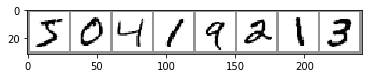

In [5]:
%matplotlib inline

writer=SummaryWriter(log_dir)
show_images=[train_ds[i][0] for i in range(8)]
show_labels=[train_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=True)
writer.add_image("mnist_images",show_img_grid)

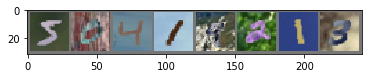

In [6]:
show_images=[train_m_ds[i][0] for i in range(8)]
show_labels=[train_m_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=False)
writer.add_image("mnist_m_images",show_img_grid)

## 独立训练

在源域上独立训练CNN模型

In [7]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
    def forward(self,x):
        x=x.expand(x.data.shape[0],3,image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

用一个5层的神经网络在mnist上使用Adam训练，准确率约为99.3%

In [8]:
cnn_model=CNN()
optimizer=Adam(cnn_model.parameters(),lr=0.001)
Loss=nn.CrossEntropyLoss()
epochs=5
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=200
cnn_model.cuda()
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_dl):
        images=images.cuda()
        labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                            train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_dl):
        images=images.cuda()
        labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

Epoch:0[200/469],Loss:[0.122,0.404],prec[96.0938,87.5273]
Epoch:0[400/469],Loss:[0.078,0.253],prec[98.4375,92.1875]




Epoch:0,val,Loss:[0.046],prec[98.4600]


Epoch:1[200/469],Loss:[0.072,0.060],prec[98.4375,98.1328]
Epoch:1[400/469],Loss:[0.030,0.056],prec[99.2188,98.2031]




Epoch:1,val,Loss:[0.045],prec[98.5700]


Epoch:2[200/469],Loss:[0.033,0.040],prec[99.2188,98.7461]
Epoch:2[400/469],Loss:[0.006,0.039],prec[100.0000,98.7422]




Epoch:2,val,Loss:[0.033],prec[98.9600]


Epoch:3[200/469],Loss:[0.083,0.030],prec[98.4375,99.0273]
Epoch:3[400/469],Loss:[0.020,0.031],prec[99.2188,99.0312]




Epoch:3,val,Loss:[0.035],prec[98.7400]


Epoch:4[200/469],Loss:[0.015,0.022],prec[100.0000,99.2773]
Epoch:4[400/469],Loss:[0.024,0.024],prec[99.2188,99.2168]




Epoch:4,val,Loss:[0.030],prec[99.1400]


## 直接迁移

直接用mnist数据集训练的网络识别mnist_m数据集，准确率约为58%.可以看作领域适应方法准确率的下界。

In [9]:
test_m_top1=AverageMeter()
test_m_loss=AverageMeter()
for images,labels in tqdm(test_m_dl):
    images=images.cuda()
    labels=labels.cuda()
    predict=cnn_model(images)
    losses=Loss(predict,labels)
    test_m_loss.update(losses.data,images.size(0))
    top1=accuracy(predict.data,labels,topk=(1,))[0]
    test_m_top1.update(top1,images.size(0))
print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_m_loss.avg,test_m_top1.avg))


Epoch:4,val,Loss:[1.303],prec[57.8491]


## 直接训练

直接使用mnist_m训练，准确率约为96%，可以看坐领域适应方法准确率的上界。

In [10]:
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=100
cnn_model.cuda()
epochs=5
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_m_dl):
        images=images.cuda()
        labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                                   train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_m_dl):
        images=images.cuda()
        labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

Epoch:0[100/469],Loss:[0.259,0.659],prec[90.6250,79.5469]
Epoch:0[200/469],Loss:[0.235,0.488],prec[91.4062,84.7852]
Epoch:0[300/469],Loss:[0.142,0.405],prec[95.3125,87.3620]
Epoch:0[400/469],Loss:[0.209,0.359],prec[94.5312,88.8027]




Epoch:0,val,Loss:[0.172],prec[94.7339]


Epoch:1[100/469],Loss:[0.107,0.163],prec[96.0938,95.0156]
Epoch:1[200/469],Loss:[0.126,0.157],prec[96.0938,95.1055]
Epoch:1[300/469],Loss:[0.120,0.153],prec[96.8750,95.1927]
Epoch:1[400/469],Loss:[0.096,0.149],prec[96.8750,95.2930]




Epoch:1,val,Loss:[0.145],prec[95.4561]


Epoch:2[100/469],Loss:[0.052,0.108],prec[99.2188,96.4062]
Epoch:2[200/469],Loss:[0.108,0.112],prec[96.8750,96.3359]
Epoch:2[300/469],Loss:[0.152,0.111],prec[93.7500,96.4141]
Epoch:2[400/469],Loss:[0.191,0.112],prec[92.9688,96.3887]




Epoch:2,val,Loss:[0.125],prec[95.9671]


Epoch:3[100/469],Loss:[0.076,0.080],prec[97.6562,97.4062]
Epoch:3[200/469],Loss:[0.157,0.084],prec[95.3125,97.3438]
Epoch:3[300/469],Loss:[0.051,0.086],prec[100.0000,97.2448]
Epoch:3[400/469],Loss:[0.116,0.087],prec[95.3125,97.1992]




Epoch:3,val,Loss:[0.114],prec[96.5337]


Epoch:4[100/469],Loss:[0.073,0.069],prec[97.6562,97.6797]
Epoch:4[200/469],Loss:[0.050,0.071],prec[98.4375,97.6055]
Epoch:4[300/469],Loss:[0.089,0.073],prec[97.6562,97.5911]
Epoch:4[400/469],Loss:[0.083,0.073],prec[96.8750,97.5703]




Epoch:4,val,Loss:[0.117],prec[96.3337]


## GRL

梯度反转层，这一层正向表现为恒等变换，反向传播是改变梯度的符号，alpha用来平衡域损失的权重。

In [11]:
from torch.autograd import Function

class GRL(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

## DANN

In [14]:
class DANN(nn.Module):
    def __init__(self,num_classes=10):
        super(DANN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.task_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
        self.domain_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,2)
        )
        self.GRL=GRL()
    def forward(self,x,alpha):
        x = x.expand(x.data.shape[0], 3, image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        task_predict=self.task_classifier(x)
        x=GRL.apply(x,alpha)
        domain_predict=self.domain_classifier(x)
        return task_predict,domain_predict

## 领域迁移训练

使用DANN进行领域迁移训练，使用mnist上的有标签数据和mnist_m上的无标签数据，准确率约为83%.

In [16]:
train_loss=AverageMeter()
train_domain_loss=AverageMeter()
train_task_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
test_domain_acc=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()

print_freq=200
domain_model=DANN()
domain_model.cuda()
domain_loss=nn.CrossEntropyLoss()
task_loss=nn.CrossEntropyLoss()
lr=0.001
optimizer=Adam(domain_model.parameters(),lr=lr)
epochs=100
for epoch in range(epochs):

    #lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_domain_loss.reset()
    train_task_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for source,target in zip(train_dl,train_m_dl):
        train_cnt.update(images.size(0),1)
        p = float(train_cnt.count + epoch * len(train_dl)) / (epochs *len(train_dl))
        alpha = torch.tensor(2. / (1. + np.exp(-10 * p)) - 1)
        src_imgs=source[0].cuda()
        src_labels=source[1].cuda()
        dst_imgs=target[0].cuda()
        optimizer.zero_grad()
        
        src_predict,src_domains=domain_model(src_imgs,alpha)
        src_label_loss=task_loss(src_predict,src_labels)
        src_domain_loss=domain_loss(src_domains,torch.ones(len(src_domains)).long().cuda())
        
        _,dst_domains=domain_model(dst_imgs,alpha)
        dst_domain_loss=domain_loss(dst_domains,torch.zeros(len(dst_domains)).long().cuda())
        
        losses=src_label_loss+src_domain_loss+dst_domain_loss
        
        train_loss.update(losses.data,images.size(0))
        train_domain_loss.update(dst_domain_loss.data,images.size(0))
        train_task_loss.update(src_label_loss.data,images.size(0))
        top1=accuracy(src_predict.data,src_labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],domain loss:[{:.3f},{:.3f}],label loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}],alpha:{}".format(
                epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                train_domain_loss.val,train_domain_loss.avg,
                train_task_loss.val,train_task_loss.avg,train_top1.val,train_top1.avg,alpha))
    for images,labels in tqdm(test_m_dl):
        images=images.cuda()
        labels=labels.cuda()
        predicts,domains=domain_model(images,0)
        losses=task_loss(predicts,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predicts.data,labels,topk=(1,))[0]
        domain_acc=accuracy(domains.data,torch.zeros(len(domains)).long().cuda(),topk=(1,))[0]
        test_top1.update(top1,images.size(0))
        test_domain_acc.update(domain_acc,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}],domain_acc[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg,test_domain_acc.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)
    writer.add_scalar("test_domain",test_domain_acc.avg,epoch)

Epoch:0[200/469],Loss:[0.977,1.207],domain loss:[0.834,0.554],label loss:[0.045,0.404],prec[98.4375,87.3945],alpha:0.02131873182952404
Epoch:0[400/469],Loss:[0.588,1.019],domain loss:[0.354,0.536],label loss:[0.063,0.250],prec[99.2188,92.2266],alpha:0.04261809214949608



Epoch:0,val,Loss:[1.235],prec[61.9376],domain_acc[77.7247]
Epoch:1[200/469],Loss:[0.590,0.574],domain loss:[0.387,0.353],label loss:[0.070,0.059],prec[97.6562,98.1211],alpha:0.07120127230882645
Epoch:1[400/469],Loss:[0.680,0.744],domain loss:[0.427,0.443],label loss:[0.134,0.070],prec[96.8750,97.8359],alpha:0.09237977862358093



Epoch:1,val,Loss:[1.270],prec[59.6600],domain_acc[79.5578]
Epoch:2[200/469],Loss:[1.079,0.687],domain loss:[0.667,0.402],label loss:[0.050,0.062],prec[98.4375,98.2266],alpha:0.1207301989197731
Epoch:2[400/469],Loss:[0.588,0.640],domain loss:[0.327,0.374],label loss:[0.033,0.061],prec[97.6562,98.1700],alpha:0.14168426394462585



Epoch:2,val,Loss:[2.051],prec[53.3163],domain_acc[81.1169]
Epoch:3[200/469],Loss:[0.423,0.677],domain loss:[0.228,0.364],label loss:[0.047,0.083],prec[98.4375,97.3984],alpha:0.16966524720191956
Epoch:3[400/469],Loss:[0.420,0.608],domain loss:[0.196,0.332],label loss:[0.021,0.068],prec[99.2188,97.9044],alpha:0.19029566645622253



Epoch:3,val,Loss:[1.395],prec[58.5602],domain_acc[81.7604]
Epoch:4[200/469],Loss:[0.604,0.528],domain loss:[0.254,0.301],label loss:[0.053,0.046],prec[97.6562,98.5703],alpha:0.21777768433094025
Epoch:4[400/469],Loss:[0.607,0.526],domain loss:[0.304,0.297],label loss:[0.155,0.048],prec[98.4375,98.5098],alpha:0.23799148201942444



Epoch:4,val,Loss:[1.358],prec[59.6711],domain_acc[83.5107]
Epoch:5[200/469],Loss:[0.468,0.484],domain loss:[0.149,0.268],label loss:[0.016,0.044],prec[99.2188,98.6211],alpha:0.2648544907569885
Epoch:5[400/469],Loss:[0.566,0.581],domain loss:[0.423,0.316],label loss:[0.009,0.056],prec[100.0000,98.2715],alpha:0.2845664620399475



Epoch:5,val,Loss:[1.644],prec[58.7268],domain_acc[85.1683]
Epoch:6[200/469],Loss:[0.435,0.690],domain loss:[0.172,0.349],label loss:[0.049,0.093],prec[99.2188,97.3672],alpha:0.31070175766944885
Epoch:6[400/469],Loss:[0.636,0.584],domain loss:[0.350,0.305],label loss:[0.057,0.072],prec[99.2188,97.9668],alpha:0.3298357427120209



Epoch:6,val,Loss:[1.433],prec[59.3823],domain_acc[86.1031]
Epoch:7[200/469],Loss:[0.778,0.570],domain loss:[0.297,0.295],label loss:[0.076,0.045],prec[97.6562,98.6719],alpha:0.35514748096466064
Epoch:7[400/469],Loss:[0.679,0.569],domain loss:[0.349,0.299],label loss:[0.050,0.053],prec[98.4375,98.4337],alpha:0.37363728880882263



Epoch:7,val,Loss:[2.182],prec[55.7605],domain_acc[84.8308]
Epoch:8[200/469],Loss:[0.832,0.692],domain loss:[0.316,0.347],label loss:[0.125,0.074],prec[95.3125,97.7735],alpha:0.39804354310035706
Epoch:8[400/469],Loss:[0.788,0.682],domain loss:[0.350,0.330],label loss:[0.109,0.068],prec[97.6562,98.0137],alpha:0.41583359241485596



Epoch:8,val,Loss:[2.493],prec[56.3937],domain_acc[84.7523]
Epoch:9[200/469],Loss:[0.866,0.985],domain loss:[0.449,0.411],label loss:[0.182,0.110],prec[95.3125,97.0898],alpha:0.4392668306827545
Epoch:9[400/469],Loss:[1.133,1.028],domain loss:[0.527,0.439],label loss:[0.245,0.114],prec[95.3125,96.8827],alpha:0.456312358379364



Epoch:9,val,Loss:[2.505],prec[59.6600],domain_acc[84.4939]
Epoch:10[200/469],Loss:[1.085,0.837],domain loss:[0.300,0.374],label loss:[0.079,0.093],prec[96.8750,97.3711],alpha:0.47871965169906616
Epoch:10[400/469],Loss:[0.775,0.984],domain loss:[0.246,0.428],label loss:[0.181,0.106],prec[95.3125,97.0684],alpha:0.49498671293258667



Epoch:10,val,Loss:[2.768],prec[58.6379],domain_acc[85.3067]
Epoch:11[200/469],Loss:[1.212,1.070],domain loss:[0.511,0.469],label loss:[0.136,0.118],prec[96.0938,96.5274],alpha:0.5163294672966003
Epoch:11[400/469],Loss:[0.963,1.081],domain loss:[0.340,0.461],label loss:[0.037,0.107],prec[99.2188,96.8262],alpha:0.5317944884300232



Epoch:11,val,Loss:[3.159],prec[58.7379],domain_acc[84.8026]
Epoch:12[200/469],Loss:[1.140,1.120],domain loss:[0.550,0.465],label loss:[0.093,0.098],prec[98.4375,96.9648],alpha:0.5520477890968323
Epoch:12[400/469],Loss:[1.227,1.088],domain loss:[0.678,0.459],label loss:[0.034,0.095],prec[99.2188,97.0781],alpha:0.5666970610618591



Epoch:12,val,Loss:[3.164],prec[59.0823],domain_acc[84.4445]
Epoch:13[200/469],Loss:[1.187,1.179],domain loss:[0.584,0.492],label loss:[0.025,0.092],prec[100.0000,97.0586],alpha:0.5858488082885742
Epoch:13[400/469],Loss:[1.255,1.212],domain loss:[0.401,0.512],label loss:[0.142,0.096],prec[94.5312,96.9726],alpha:0.5996778011322021



Epoch:13,val,Loss:[2.182],prec[60.5155],domain_acc[84.3859]
Epoch:14[200/469],Loss:[1.176,1.073],domain loss:[0.594,0.531],label loss:[0.116,0.088],prec[96.0938,97.3906],alpha:0.617727518081665
Epoch:14[400/469],Loss:[1.090,1.080],domain loss:[0.574,0.528],label loss:[0.044,0.080],prec[97.6562,97.5937],alpha:0.6307399272918701



Epoch:14,val,Loss:[1.604],prec[63.7151],domain_acc[83.0374]
Epoch:15[200/469],Loss:[1.137,1.140],domain loss:[0.466,0.541],label loss:[0.039,0.071],prec[99.2188,97.8750],alpha:0.6476975083351135
Epoch:15[400/469],Loss:[1.162,1.169],domain loss:[0.476,0.546],label loss:[0.074,0.074],prec[97.6562,97.7735],alpha:0.6599041819572449



Epoch:15,val,Loss:[1.526],prec[63.5929],domain_acc[81.8013]
Epoch:16[200/469],Loss:[1.116,1.225],domain loss:[0.450,0.581],label loss:[0.057,0.088],prec[97.6562,97.4453],alpha:0.6757887601852417
Epoch:16[400/469],Loss:[1.375,1.208],domain loss:[0.455,0.596],label loss:[0.057,0.080],prec[96.8750,97.6153],alpha:0.6872069239616394



Epoch:16,val,Loss:[2.131],prec[63.8151],domain_acc[81.1773]
Epoch:17[200/469],Loss:[1.303,1.195],domain loss:[0.506,0.599],label loss:[0.081,0.061],prec[96.8750,98.1289],alpha:0.7020451426506042
Epoch:17[400/469],Loss:[1.180,1.224],domain loss:[0.581,0.595],label loss:[0.040,0.064],prec[98.4375,98.0879],alpha:0.7126971483230591



Epoch:17,val,Loss:[1.716],prec[63.7596],domain_acc[80.7886]
Epoch:18[200/469],Loss:[1.187,1.161],domain loss:[0.540,0.569],label loss:[0.056,0.063],prec[97.6562,98.0937],alpha:0.7265222072601318
Epoch:18[400/469],Loss:[1.231,1.177],domain loss:[0.569,0.583],label loss:[0.080,0.067],prec[96.8750,97.9551],alpha:0.7364346385002136



Epoch:18,val,Loss:[1.434],prec[66.9037],domain_acc[79.5607]
Epoch:19[200/469],Loss:[1.329,1.167],domain loss:[0.533,0.592],label loss:[0.099,0.069],prec[97.6562,97.8828],alpha:0.7492846250534058
Epoch:19[400/469],Loss:[1.335,1.199],domain loss:[0.673,0.604],label loss:[0.091,0.070],prec[97.6562,97.8516],alpha:0.7584874629974365



Epoch:19,val,Loss:[1.422],prec[66.1704],domain_acc[78.2974]
Epoch:20[200/469],Loss:[1.086,1.225],domain loss:[0.452,0.589],label loss:[0.025,0.070],prec[99.2188,97.8164],alpha:0.7704044580459595
Epoch:20[400/469],Loss:[1.204,1.218],domain loss:[0.556,0.596],label loss:[0.056,0.066],prec[97.6562,97.9688],alpha:0.7789300084114075



Epoch:20,val,Loss:[1.460],prec[67.2814],domain_acc[77.7977]
Epoch:21[200/469],Loss:[1.236,1.264],domain loss:[0.524,0.613],label loss:[0.107,0.082],prec[97.6562,97.5078],alpha:0.7899587750434875
Epoch:21[400/469],Loss:[1.133,1.229],domain loss:[0.574,0.602],label loss:[0.077,0.071],prec[97.6562,97.8496],alpha:0.7978411316871643



Epoch:21,val,Loss:[1.560],prec[67.6814],domain_acc[77.4611]
Epoch:22[200/469],Loss:[1.147,1.206],domain loss:[0.509,0.580],label loss:[0.048,0.069],prec[99.2188,97.8867],alpha:0.8080282211303711
Epoch:22[400/469],Loss:[1.253,1.209],domain loss:[0.543,0.587],label loss:[0.050,0.064],prec[97.6562,98.0177],alpha:0.8153024911880493



Epoch:22,val,Loss:[1.462],prec[69.1256],domain_acc[77.3204]
Epoch:23[200/469],Loss:[1.171,1.212],domain loss:[0.594,0.602],label loss:[0.065,0.061],prec[98.4375,98.1055],alpha:0.8246954679489136
Epoch:23[400/469],Loss:[1.253,1.242],domain loss:[0.606,0.615],label loss:[0.084,0.062],prec[96.0938,98.0821],alpha:0.8313970565795898



Epoch:23,val,Loss:[1.503],prec[68.2035],domain_acc[76.7405]
Epoch:24[200/469],Loss:[1.364,1.294],domain loss:[0.612,0.623],label loss:[0.036,0.065],prec[98.4375,97.9492],alpha:0.8400437235832214
Epoch:24[400/469],Loss:[1.162,1.266],domain loss:[0.560,0.614],label loss:[0.016,0.067],prec[100.0000,97.9180],alpha:0.8462079763412476



Epoch:24,val,Loss:[1.255],prec[70.6477],domain_acc[76.1213]
Epoch:25[200/469],Loss:[1.339,1.272],domain loss:[0.603,0.616],label loss:[0.040,0.057],prec[98.4375,98.1484],alpha:0.8541555404663086
Epoch:25[400/469],Loss:[1.317,1.279],domain loss:[0.699,0.620],label loss:[0.068,0.064],prec[96.8750,97.9337],alpha:0.859817385673523



Epoch:25,val,Loss:[1.403],prec[68.1702],domain_acc[74.8118]
Epoch:26[200/469],Loss:[1.318,1.301],domain loss:[0.689,0.652],label loss:[0.079,0.067],prec[96.8750,98.0039],alpha:0.8671122789382935
Epoch:26[400/469],Loss:[1.306,1.289],domain loss:[0.633,0.638],label loss:[0.062,0.063],prec[97.6562,98.1134],alpha:0.8723058104515076



Epoch:26,val,Loss:[1.301],prec[70.3700],domain_acc[73.7046]
Epoch:27[200/469],Loss:[1.378,1.292],domain loss:[0.676,0.638],label loss:[0.098,0.056],prec[97.6562,98.2617],alpha:0.8789930939674377
Epoch:27[400/469],Loss:[1.378,1.323],domain loss:[0.705,0.640],label loss:[0.103,0.065],prec[96.0938,97.9454],alpha:0.8837512135505676



Epoch:27,val,Loss:[1.325],prec[69.5145],domain_acc[72.2828]
Epoch:28[200/469],Loss:[1.366,1.303],domain loss:[0.734,0.665],label loss:[0.111,0.062],prec[96.8750,98.0976],alpha:0.8898743987083435
Epoch:28[400/469],Loss:[1.413,1.328],domain loss:[0.796,0.649],label loss:[0.141,0.066],prec[96.0938,98.0234],alpha:0.8942286968231201



Epoch:28,val,Loss:[1.496],prec[67.2148],domain_acc[71.9464]
Epoch:29[200/469],Loss:[1.325,1.364],domain loss:[0.698,0.676],label loss:[0.025,0.055],prec[99.2188,98.2813],alpha:0.8998293280601501
Epoch:29[400/469],Loss:[1.473,1.358],domain loss:[0.803,0.664],label loss:[0.022,0.057],prec[99.2188,98.1955],alpha:0.9038100838661194



Epoch:29,val,Loss:[1.179],prec[71.0588],domain_acc[71.7839]
Epoch:30[200/469],Loss:[1.335,1.354],domain loss:[0.708,0.659],label loss:[0.076,0.047],prec[98.4375,98.5352],alpha:0.9089277386665344
Epoch:30[400/469],Loss:[1.339,1.345],domain loss:[0.717,0.660],label loss:[0.052,0.053],prec[99.2188,98.3848],alpha:0.9125635623931885



Epoch:30,val,Loss:[1.310],prec[71.6476],domain_acc[71.8949]
Epoch:31[200/469],Loss:[1.433,1.362],domain loss:[0.734,0.641],label loss:[0.038,0.050],prec[98.4375,98.3359],alpha:0.917235791683197
Epoch:31[400/469],Loss:[1.322,1.374],domain loss:[0.742,0.649],label loss:[0.006,0.055],prec[100.0000,98.3087],alpha:0.9205537438392639



Epoch:31,val,Loss:[1.133],prec[73.9362],domain_acc[70.8841]
Epoch:32[200/469],Loss:[1.366,1.353],domain loss:[0.647,0.679],label loss:[0.087,0.052],prec[97.6562,98.3711],alpha:0.9248157739639282
Epoch:32[400/469],Loss:[1.395,1.352],domain loss:[0.747,0.663],label loss:[0.025,0.055],prec[99.2188,98.3204],alpha:0.9278412461280823



Epoch:32,val,Loss:[1.078],prec[73.2807],domain_acc[70.5430]
Epoch:33[200/469],Loss:[1.245,1.317],domain loss:[0.634,0.649],label loss:[0.003,0.057],prec[100.0000,98.2539],alpha:0.9317262768745422
Epoch:33[400/469],Loss:[1.364,1.321],domain loss:[0.676,0.649],label loss:[0.025,0.059],prec[99.2188,98.2443],alpha:0.9344831109046936



Epoch:33,val,Loss:[1.039],prec[73.8362],domain_acc[70.1007]
Epoch:34[200/469],Loss:[1.439,1.376],domain loss:[0.764,0.661],label loss:[0.028,0.052],prec[99.2188,98.4571],alpha:0.9380220174789429
Epoch:34[400/469],Loss:[1.385,1.362],domain loss:[0.660,0.660],label loss:[0.096,0.056],prec[97.6562,98.3126],alpha:0.9405325055122375



Epoch:34,val,Loss:[1.322],prec[72.0142],domain_acc[70.0262]
Epoch:35[200/469],Loss:[1.346,1.400],domain loss:[0.574,0.678],label loss:[0.050,0.065],prec[97.6562,98.0196],alpha:0.9437541365623474
Epoch:35[400/469],Loss:[1.473,1.391],domain loss:[0.654,0.661],label loss:[0.147,0.062],prec[96.8750,98.1114],alpha:0.9460389018058777



Epoch:35,val,Loss:[1.067],prec[74.5695],domain_acc[69.7401]
Epoch:36[200/469],Loss:[1.369,1.369],domain loss:[0.673,0.655],label loss:[0.096,0.051],prec[98.4375,98.3906],alpha:0.9489700794219971
Epoch:36[400/469],Loss:[1.351,1.377],domain loss:[0.649,0.665],label loss:[0.017,0.052],prec[100.0000,98.3888],alpha:0.9510483145713806



Epoch:36,val,Loss:[1.088],prec[74.8361],domain_acc[69.7823]
Epoch:37[200/469],Loss:[1.310,1.405],domain loss:[0.613,0.672],label loss:[0.001,0.054],prec[100.0000,98.3867],alpha:0.9537138342857361
Epoch:37[400/469],Loss:[1.429,1.407],domain loss:[0.674,0.679],label loss:[0.071,0.052],prec[99.2188,98.4082],alpha:0.9556032419204712



Epoch:37,val,Loss:[1.119],prec[75.4583],domain_acc[69.6753]
Epoch:38[200/469],Loss:[1.348,1.359],domain loss:[0.700,0.651],label loss:[0.009,0.045],prec[100.0000,98.6133],alpha:0.958026111125946
Epoch:38[400/469],Loss:[1.480,1.368],domain loss:[0.653,0.666],label loss:[0.076,0.046],prec[97.6562,98.5723],alpha:0.9597431421279907



Epoch:38,val,Loss:[1.032],prec[75.5694],domain_acc[69.7851]
Epoch:39[200/469],Loss:[1.395,1.401],domain loss:[0.688,0.683],label loss:[0.086,0.050],prec[97.6562,98.5117],alpha:0.9619444608688354
Epoch:39[400/469],Loss:[1.435,1.398],domain loss:[0.684,0.681],label loss:[0.091,0.050],prec[96.8750,98.4728],alpha:0.9635041356086731



Epoch:39,val,Loss:[1.097],prec[75.5249],domain_acc[69.7114]
Epoch:40[200/469],Loss:[1.443,1.339],domain loss:[0.658,0.649],label loss:[0.103,0.057],prec[96.0938,98.2422],alpha:0.965503454208374
Epoch:40[400/469],Loss:[1.379,1.353],domain loss:[0.656,0.662],label loss:[0.056,0.055],prec[97.6562,98.3165],alpha:0.9669197797775269



Epoch:40,val,Loss:[0.865],prec[78.0802],domain_acc[69.5400]
Epoch:41[200/469],Loss:[1.373,1.357],domain loss:[0.680,0.660],label loss:[0.088,0.045],prec[98.4375,98.5274],alpha:0.9687349200248718
Epoch:41[400/469],Loss:[1.394,1.371],domain loss:[0.720,0.662],label loss:[0.057,0.049],prec[96.8750,98.4669],alpha:0.970020592212677



Epoch:41,val,Loss:[1.078],prec[76.8026],domain_acc[69.6777]
Epoch:42[200/469],Loss:[1.388,1.379],domain loss:[0.692,0.665],label loss:[0.031,0.044],prec[99.2188,98.5899],alpha:0.971668004989624
Epoch:42[400/469],Loss:[1.337,1.374],domain loss:[0.611,0.664],label loss:[0.029,0.044],prec[98.4375,98.6700],alpha:0.9728347659111023



Epoch:42,val,Loss:[0.972],prec[76.1915],domain_acc[69.5295]
Epoch:43[200/469],Loss:[1.393,1.359],domain loss:[0.705,0.668],label loss:[0.048,0.047],prec[98.4375,98.5898],alpha:0.9743295311927795
Epoch:43[400/469],Loss:[1.407,1.379],domain loss:[0.633,0.673],label loss:[0.065,0.050],prec[98.4375,98.4435],alpha:0.9753880500793457



Epoch:43,val,Loss:[0.850],prec[77.3803],domain_acc[69.6466]
Epoch:44[200/469],Loss:[1.440,1.383],domain loss:[0.661,0.670],label loss:[0.060,0.044],prec[96.8750,98.6211],alpha:0.9767439961433411
Epoch:44[400/469],Loss:[1.424,1.380],domain loss:[0.641,0.667],label loss:[0.072,0.050],prec[98.4375,98.4454],alpha:0.9777040481567383



Epoch:44,val,Loss:[0.961],prec[74.6139],domain_acc[69.9088]
Epoch:45[200/469],Loss:[1.290,1.385],domain loss:[0.677,0.680],label loss:[0.024,0.040],prec[100.0000,98.6875],alpha:0.9789338111877441
Epoch:45[400/469],Loss:[1.395,1.394],domain loss:[0.682,0.672],label loss:[0.040,0.044],prec[99.2188,98.6173],alpha:0.9798043966293335



Epoch:45,val,Loss:[1.007],prec[77.3692],domain_acc[70.1354]
Epoch:46[200/469],Loss:[1.347,1.399],domain loss:[0.709,0.683],label loss:[0.020,0.035],prec[99.2188,98.9259],alpha:0.9809194207191467
Epoch:46[400/469],Loss:[1.384,1.396],domain loss:[0.620,0.676],label loss:[0.005,0.038],prec[100.0000,98.8009],alpha:0.9817086458206177



Epoch:46,val,Loss:[1.063],prec[75.3916],domain_acc[69.5994]
Epoch:47[200/469],Loss:[1.356,1.400],domain loss:[0.640,0.686],label loss:[0.005,0.039],prec[100.0000,98.7422],alpha:0.9827194809913635
Epoch:47[400/469],Loss:[1.326,1.395],domain loss:[0.675,0.682],label loss:[0.020,0.040],prec[99.2188,98.7462],alpha:0.9834349155426025



Epoch:47,val,Loss:[1.183],prec[75.9471],domain_acc[69.7166]
Epoch:48[200/469],Loss:[1.408,1.402],domain loss:[0.653,0.668],label loss:[0.072,0.037],prec[96.8750,98.8985],alpha:0.9843510389328003
Epoch:48[400/469],Loss:[1.388,1.400],domain loss:[0.690,0.680],label loss:[0.028,0.038],prec[99.2188,98.8537],alpha:0.9849994778633118



Epoch:48,val,Loss:[1.001],prec[74.5695],domain_acc[69.6422]
Epoch:49[200/469],Loss:[1.408,1.399],domain loss:[0.704,0.683],label loss:[0.015,0.041],prec[100.0000,98.7031],alpha:0.9858297109603882
Epoch:49[400/469],Loss:[1.462,1.399],domain loss:[0.521,0.680],label loss:[0.075,0.041],prec[98.4375,98.7384],alpha:0.9864172339439392



Epoch:49,val,Loss:[0.931],prec[77.0581],domain_acc[68.3082]
Epoch:50[200/469],Loss:[1.458,1.377],domain loss:[0.686,0.704],label loss:[0.077,0.034],prec[98.4375,98.9336],alpha:0.9871695041656494
Epoch:50[400/469],Loss:[1.392,1.396],domain loss:[0.658,0.690],label loss:[0.033,0.035],prec[99.2188,98.8575],alpha:0.9877018928527832



Epoch:50,val,Loss:[1.146],prec[75.4472],domain_acc[68.4752]
Epoch:51[200/469],Loss:[1.377,1.402],domain loss:[0.651,0.685],label loss:[0.009,0.030],prec[100.0000,99.0196],alpha:0.988383412361145
Epoch:51[400/469],Loss:[1.443,1.405],domain loss:[0.708,0.687],label loss:[0.087,0.033],prec[99.2188,98.9768],alpha:0.9888656735420227



Epoch:51,val,Loss:[1.015],prec[77.7914],domain_acc[68.4930]
Epoch:52[200/469],Loss:[1.310,1.381],domain loss:[0.632,0.679],label loss:[0.002,0.041],prec[100.0000,98.7461],alpha:0.9894830584526062
Epoch:52[400/469],Loss:[1.392,1.391],domain loss:[0.706,0.681],label loss:[0.038,0.038],prec[99.2188,98.8615],alpha:0.989919900894165



Epoch:52,val,Loss:[0.988],prec[77.6691],domain_acc[68.6668]
Epoch:53[200/469],Loss:[1.410,1.397],domain loss:[0.738,0.686],label loss:[0.030,0.025],prec[99.2188,99.2032],alpha:0.9904791116714478
Epoch:53[400/469],Loss:[1.373,1.397],domain loss:[0.686,0.685],label loss:[0.019,0.031],prec[99.2188,99.0295],alpha:0.9908747673034668



Epoch:53,val,Loss:[1.069],prec[75.2805],domain_acc[68.4910]
Epoch:54[200/469],Loss:[1.453,1.401],domain loss:[0.719,0.685],label loss:[0.064,0.035],prec[98.4375,98.8438],alpha:0.9913812279701233
Epoch:54[400/469],Loss:[1.480,1.400],domain loss:[0.754,0.681],label loss:[0.097,0.040],prec[96.8750,98.7131],alpha:0.9917395710945129



Epoch:54,val,Loss:[1.096],prec[75.6583],domain_acc[68.5237]
Epoch:55[200/469],Loss:[1.344,1.401],domain loss:[0.675,0.678],label loss:[0.019,0.035],prec[99.2188,98.9336],alpha:0.9921982288360596
Epoch:55[400/469],Loss:[1.430,1.401],domain loss:[0.656,0.682],label loss:[0.046,0.035],prec[97.6562,98.9611],alpha:0.9925227165222168



Epoch:55,val,Loss:[0.854],prec[78.0358],domain_acc[67.6546]
Epoch:56[200/469],Loss:[1.389,1.368],domain loss:[0.619,0.678],label loss:[0.037,0.028],prec[98.4375,99.1484],alpha:0.9929380416870117
Epoch:56[400/469],Loss:[1.428,1.387],domain loss:[0.670,0.681],label loss:[0.055,0.030],prec[97.6562,99.0392],alpha:0.9932318925857544



Epoch:56,val,Loss:[0.887],prec[76.8803],domain_acc[67.8876]
Epoch:57[200/469],Loss:[1.395,1.386],domain loss:[0.659,0.680],label loss:[0.051,0.031],prec[97.6562,99.0156],alpha:0.9936079382896423
Epoch:57[400/469],Loss:[1.306,1.392],domain loss:[0.588,0.675],label loss:[0.044,0.037],prec[97.6562,98.8556],alpha:0.9938739538192749



Epoch:57,val,Loss:[0.955],prec[76.1138],domain_acc[67.2845]
Epoch:58[200/469],Loss:[1.356,1.386],domain loss:[0.668,0.685],label loss:[0.017,0.037],prec[99.2188,98.8789],alpha:0.9942144751548767
Epoch:58[400/469],Loss:[1.368,1.395],domain loss:[0.637,0.686],label loss:[0.007,0.042],prec[100.0000,98.7540],alpha:0.9944553375244141



Epoch:58,val,Loss:[1.009],prec[76.2693],domain_acc[66.7252]
Epoch:59[200/469],Loss:[1.336,1.382],domain loss:[0.621,0.679],label loss:[0.009,0.030],prec[100.0000,99.0860],alpha:0.9947636127471924
Epoch:59[400/469],Loss:[1.442,1.386],domain loss:[0.716,0.682],label loss:[0.098,0.031],prec[96.0938,98.9963],alpha:0.9949816465377808



Epoch:59,val,Loss:[1.003],prec[77.1914],domain_acc[66.6594]
Epoch:60[200/469],Loss:[1.270,1.497],domain loss:[0.593,0.691],label loss:[0.047,0.128],prec[98.4375,96.3789],alpha:0.9952607154846191
Epoch:60[400/469],Loss:[1.309,1.406],domain loss:[0.609,0.666],label loss:[0.069,0.093],prec[99.2188,97.3869],alpha:0.9954581260681152



Epoch:60,val,Loss:[1.226],prec[76.1249],domain_acc[65.8433]
Epoch:61[200/469],Loss:[1.397,1.365],domain loss:[0.680,0.682],label loss:[0.019,0.040],prec[99.2188,98.8047],alpha:0.9957107305526733
Epoch:61[400/469],Loss:[1.417,1.376],domain loss:[0.691,0.673],label loss:[0.046,0.040],prec[97.6562,98.7735],alpha:0.99588942527771



Epoch:61,val,Loss:[0.785],prec[78.3135],domain_acc[65.3096]
Epoch:62[200/469],Loss:[1.357,1.382],domain loss:[0.637,0.682],label loss:[0.008,0.037],prec[100.0000,98.9414],alpha:0.9961181282997131
Epoch:62[400/469],Loss:[1.434,1.387],domain loss:[0.689,0.681],label loss:[0.047,0.036],prec[98.4375,98.8986],alpha:0.9962798953056335



Epoch:62,val,Loss:[0.867],prec[78.3135],domain_acc[65.4645]
Epoch:63[200/469],Loss:[1.364,1.394],domain loss:[0.688,0.687],label loss:[0.007,0.026],prec[100.0000,99.1915],alpha:0.9964869022369385
Epoch:63[400/469],Loss:[1.405,1.397],domain loss:[0.641,0.683],label loss:[0.006,0.028],prec[100.0000,99.1154],alpha:0.9966332912445068



Epoch:63,val,Loss:[0.790],prec[79.5800],domain_acc[65.6970]
Epoch:64[200/469],Loss:[1.436,1.387],domain loss:[0.702,0.676],label loss:[0.099,0.024],prec[98.4375,99.2696],alpha:0.9968206882476807
Epoch:64[400/469],Loss:[1.397,1.393],domain loss:[0.609,0.684],label loss:[0.032,0.029],prec[99.2188,99.0939],alpha:0.9969531893730164



Epoch:64,val,Loss:[0.901],prec[78.1691],domain_acc[65.8332]
Epoch:65[200/469],Loss:[1.374,1.396],domain loss:[0.671,0.680],label loss:[0.027,0.036],prec[98.4375,98.8477],alpha:0.9971228241920471
Epoch:65[400/469],Loss:[1.376,1.396],domain loss:[0.672,0.688],label loss:[0.026,0.029],prec[99.2188,99.0724],alpha:0.9972427487373352



Epoch:65,val,Loss:[0.950],prec[77.6025],domain_acc[66.1125]
Epoch:66[200/469],Loss:[1.402,1.388],domain loss:[0.632,0.676],label loss:[0.050,0.025],prec[98.4375,99.1719],alpha:0.9973962306976318
Epoch:66[400/469],Loss:[1.427,1.393],domain loss:[0.701,0.683],label loss:[0.031,0.028],prec[99.2188,99.0822],alpha:0.9975048303604126



Epoch:66,val,Loss:[0.899],prec[78.4468],domain_acc[66.2366]
Epoch:67[200/469],Loss:[1.457,1.396],domain loss:[0.718,0.691],label loss:[0.081,0.026],prec[99.2188,99.1328],alpha:0.9976437091827393
Epoch:67[400/469],Loss:[1.398,1.399],domain loss:[0.689,0.687],label loss:[0.013,0.025],prec[99.2188,99.1818],alpha:0.9977419972419739



Epoch:67,val,Loss:[0.867],prec[79.5578],domain_acc[65.6435]
Epoch:68[200/469],Loss:[1.405,1.388],domain loss:[0.697,0.687],label loss:[0.055,0.024],prec[98.4375,99.2266],alpha:0.9978677034378052
Epoch:68[400/469],Loss:[1.365,1.386],domain loss:[0.635,0.686],label loss:[0.035,0.025],prec[99.2188,99.1682],alpha:0.9979566335678101



Epoch:68,val,Loss:[0.813],prec[79.6911],domain_acc[65.3914]
Epoch:69[200/469],Loss:[1.357,1.388],domain loss:[0.700,0.685],label loss:[0.019,0.028],prec[99.2188,99.1445],alpha:0.9980704188346863
Epoch:69[400/469],Loss:[1.396,1.390],domain loss:[0.639,0.686],label loss:[0.027,0.028],prec[99.2188,99.1329],alpha:0.9981509447097778



Epoch:69,val,Loss:[0.873],prec[78.9579],domain_acc[65.4430]
Epoch:70[200/469],Loss:[1.300,1.391],domain loss:[0.680,0.679],label loss:[0.012,0.032],prec[100.0000,99.0469],alpha:0.9982538819313049
Epoch:70[400/469],Loss:[1.335,1.384],domain loss:[0.706,0.676],label loss:[0.007,0.036],prec[100.0000,98.9396],alpha:0.9983267188072205



Epoch:70,val,Loss:[0.893],prec[78.1802],domain_acc[65.6498]
Epoch:71[200/469],Loss:[1.329,1.361],domain loss:[0.673,0.663],label loss:[0.051,0.040],prec[99.2188,98.7930],alpha:0.9984199404716492
Epoch:71[400/469],Loss:[1.400,1.362],domain loss:[0.656,0.666],label loss:[0.042,0.039],prec[98.4375,98.8165],alpha:0.9984858632087708



Epoch:71,val,Loss:[0.854],prec[79.0023],domain_acc[65.8379]
Epoch:72[200/469],Loss:[1.333,1.375],domain loss:[0.730,0.678],label loss:[0.006,0.037],prec[100.0000,98.9063],alpha:0.9985702037811279
Epoch:72[400/469],Loss:[1.376,1.378],domain loss:[0.673,0.674],label loss:[0.009,0.040],prec[100.0000,98.8087],alpha:0.9986298084259033



Epoch:72,val,Loss:[0.760],prec[80.7021],domain_acc[65.6793]
Epoch:73[200/469],Loss:[1.437,1.385],domain loss:[0.700,0.681],label loss:[0.075,0.035],prec[97.6562,98.9024],alpha:0.9987061619758606
Epoch:73[400/469],Loss:[1.447,1.381],domain loss:[0.768,0.674],label loss:[0.043,0.041],prec[99.2188,98.7443],alpha:0.9987601637840271



Epoch:73,val,Loss:[1.020],prec[76.4248],domain_acc[65.5121]
Epoch:74[200/469],Loss:[1.376,1.382],domain loss:[0.783,0.686],label loss:[0.005,0.036],prec[100.0000,98.8008],alpha:0.9988292455673218
Epoch:74[400/469],Loss:[1.359,1.377],domain loss:[0.609,0.676],label loss:[0.080,0.038],prec[98.4375,98.8127],alpha:0.9988780617713928



Epoch:74,val,Loss:[0.997],prec[76.9803],domain_acc[65.4960]
Epoch:75[200/469],Loss:[1.444,1.358],domain loss:[0.660,0.675],label loss:[0.033,0.034],prec[98.4375,98.9571],alpha:0.9989405870437622
Epoch:75[400/469],Loss:[1.429,1.362],domain loss:[0.699,0.666],label loss:[0.063,0.032],prec[98.4375,99.0275],alpha:0.9989847540855408



Epoch:75,val,Loss:[0.864],prec[79.2467],domain_acc[65.3131]
Epoch:76[200/469],Loss:[1.359,1.377],domain loss:[0.662,0.679],label loss:[0.022,0.034],prec[99.2188,98.9375],alpha:0.9990413188934326
Epoch:76[400/469],Loss:[1.353,1.385],domain loss:[0.653,0.682],label loss:[0.010,0.037],prec[99.2188,98.8810],alpha:0.9990813732147217



Epoch:76,val,Loss:[1.154],prec[75.8027],domain_acc[65.4373]
Epoch:77[200/469],Loss:[1.382,1.377],domain loss:[0.690,0.679],label loss:[0.040,0.032],prec[99.2188,98.9570],alpha:0.999132513999939
Epoch:77[400/469],Loss:[1.426,1.386],domain loss:[0.677,0.684],label loss:[0.049,0.033],prec[98.4375,98.9728],alpha:0.9991687536239624



Epoch:77,val,Loss:[0.947],prec[78.2580],domain_acc[65.4437]
Epoch:78[200/469],Loss:[1.463,1.382],domain loss:[0.666,0.675],label loss:[0.069,0.033],prec[96.8750,99.0469],alpha:0.9992150664329529
Epoch:78[400/469],Loss:[1.367,1.382],domain loss:[0.702,0.677],label loss:[0.002,0.031],prec[100.0000,99.0432],alpha:0.9992477893829346



Epoch:78,val,Loss:[1.023],prec[77.1137],domain_acc[65.3608]
Epoch:79[200/469],Loss:[1.536,1.374],domain loss:[0.686,0.667],label loss:[0.162,0.035],prec[97.6562,98.9766],alpha:0.9992896914482117
Epoch:79[400/469],Loss:[1.404,1.374],domain loss:[0.604,0.674],label loss:[0.054,0.034],prec[98.4375,98.9474],alpha:0.9993193745613098



Epoch:79,val,Loss:[0.971],prec[77.9580],domain_acc[65.3259]
Epoch:80[200/469],Loss:[1.495,1.364],domain loss:[0.709,0.660],label loss:[0.039,0.032],prec[99.2188,99.0274],alpha:0.999357283115387
Epoch:80[400/469],Loss:[1.362,1.371],domain loss:[0.709,0.667],label loss:[0.004,0.036],prec[100.0000,98.8966],alpha:0.9993841052055359



Epoch:80,val,Loss:[0.902],prec[78.4357],domain_acc[65.2594]
Epoch:81[200/469],Loss:[1.364,1.356],domain loss:[0.604,0.656],label loss:[0.039,0.040],prec[98.4375,98.7539],alpha:0.9994184374809265
Epoch:81[400/469],Loss:[1.325,1.351],domain loss:[0.713,0.659],label loss:[0.009,0.036],prec[100.0000,98.8459],alpha:0.9994426965713501



Epoch:81,val,Loss:[0.820],prec[79.7023],domain_acc[65.2285]
Epoch:82[200/469],Loss:[1.362,1.366],domain loss:[0.671,0.674],label loss:[0.043,0.037],prec[98.4375,98.8555],alpha:0.9994737505912781
Epoch:82[400/469],Loss:[1.322,1.373],domain loss:[0.675,0.672],label loss:[0.035,0.040],prec[99.2188,98.7677],alpha:0.9994957447052002



Epoch:82,val,Loss:[0.930],prec[78.3580],domain_acc[65.1620]
Epoch:83[200/469],Loss:[1.405,1.348],domain loss:[0.659,0.657],label loss:[0.045,0.038],prec[97.6562,98.8945],alpha:0.9995238184928894
Epoch:83[400/469],Loss:[1.356,1.364],domain loss:[0.645,0.670],label loss:[0.008,0.041],prec[100.0000,98.7911],alpha:0.9995437264442444



Epoch:83,val,Loss:[0.979],prec[77.4247],domain_acc[65.1898]
Epoch:84[200/469],Loss:[1.335,1.372],domain loss:[0.679,0.669],label loss:[0.036,0.038],prec[99.2188,98.7734],alpha:0.9995691180229187
Epoch:84[400/469],Loss:[1.263,1.377],domain loss:[0.619,0.669],label loss:[0.006,0.048],prec[100.0000,98.5899],alpha:0.9995871186256409



Epoch:84,val,Loss:[0.691],prec[81.2243],domain_acc[65.2196]
Epoch:85[200/469],Loss:[1.285,1.403],domain loss:[0.634,0.684],label loss:[0.014,0.048],prec[100.0000,98.6211],alpha:0.9996101260185242
Epoch:85[400/469],Loss:[1.361,1.395],domain loss:[0.666,0.676],label loss:[0.042,0.051],prec[99.2188,98.5098],alpha:0.9996263980865479



Epoch:85,val,Loss:[0.906],prec[77.6136],domain_acc[65.2616]
Epoch:86[200/469],Loss:[1.423,1.373],domain loss:[0.752,0.662],label loss:[0.048,0.034],prec[98.4375,98.9531],alpha:0.9996472001075745
Epoch:86[400/469],Loss:[1.276,1.374],domain loss:[0.674,0.667],label loss:[0.008,0.038],prec[100.0000,98.8243],alpha:0.999661922454834



Epoch:86,val,Loss:[0.973],prec[78.2135],domain_acc[65.2598]
Epoch:87[200/469],Loss:[1.466,1.367],domain loss:[0.668,0.681],label loss:[0.060,0.030],prec[98.4375,99.1094],alpha:0.9996808171272278
Epoch:87[400/469],Loss:[1.342,1.375],domain loss:[0.646,0.678],label loss:[0.023,0.032],prec[99.2188,99.0392],alpha:0.9996941089630127



Epoch:87,val,Loss:[0.862],prec[79.2467],domain_acc[65.5208]
Epoch:88[200/469],Loss:[1.309,1.361],domain loss:[0.670,0.666],label loss:[0.002,0.029],prec[100.0000,99.0899],alpha:0.9997111558914185
Epoch:88[400/469],Loss:[1.382,1.365],domain loss:[0.699,0.670],label loss:[0.050,0.033],prec[99.2188,98.9571],alpha:0.9997231960296631



Epoch:88,val,Loss:[0.873],prec[79.3134],domain_acc[65.5149]
Epoch:89[200/469],Loss:[1.396,1.363],domain loss:[0.728,0.671],label loss:[0.025,0.033],prec[99.2188,98.9649],alpha:0.9997386336326599
Epoch:89[400/469],Loss:[1.380,1.367],domain loss:[0.740,0.669],label loss:[0.033,0.035],prec[98.4375,98.9025],alpha:0.9997495412826538



Epoch:89,val,Loss:[0.965],prec[77.7691],domain_acc[65.4788]
Epoch:90[200/469],Loss:[1.369,1.447],domain loss:[0.689,0.692],label loss:[0.042,0.091],prec[98.4375,97.8516],alpha:0.9997634887695312
Epoch:90[400/469],Loss:[1.484,1.404],domain loss:[0.628,0.680],label loss:[0.123,0.069],prec[96.8750,98.2248],alpha:0.999773383140564



Epoch:90,val,Loss:[0.894],prec[78.2913],domain_acc[65.5167]
Epoch:91[200/469],Loss:[1.318,1.337],domain loss:[0.655,0.655],label loss:[0.080,0.043],prec[98.4375,98.7071],alpha:0.9997860193252563
Epoch:91[400/469],Loss:[1.217,1.349],domain loss:[0.517,0.654],label loss:[0.026,0.056],prec[99.2188,98.4826],alpha:0.9997949600219727



Epoch:91,val,Loss:[1.070],prec[76.6359],domain_acc[65.2487]
Epoch:92[200/469],Loss:[1.336,1.331],domain loss:[0.750,0.685],label loss:[0.038,0.035],prec[99.2188,98.8243],alpha:0.9998064041137695
Epoch:92[400/469],Loss:[1.452,1.349],domain loss:[0.637,0.669],label loss:[0.054,0.038],prec[99.2188,98.8205],alpha:0.9998144507408142



Epoch:92,val,Loss:[0.914],prec[78.7024],domain_acc[65.2878]
Epoch:93[200/469],Loss:[1.397,1.375],domain loss:[0.672,0.673],label loss:[0.033,0.032],prec[99.2188,98.9805],alpha:0.9998248219490051
Epoch:93[400/469],Loss:[1.362,1.374],domain loss:[0.587,0.669],label loss:[0.017,0.032],prec[99.2188,99.0197],alpha:0.9998320937156677



Epoch:93,val,Loss:[0.766],prec[81.4798],domain_acc[65.0748]
Epoch:94[200/469],Loss:[1.348,1.386],domain loss:[0.710,0.697],label loss:[0.028,0.024],prec[98.4375,99.2578],alpha:0.9998414516448975
Epoch:94[400/469],Loss:[1.477,1.380],domain loss:[0.746,0.682],label loss:[0.016,0.029],prec[99.2188,99.0763],alpha:0.9998480677604675



Epoch:94,val,Loss:[0.768],prec[81.1021],domain_acc[65.1909]
Epoch:95[200/469],Loss:[1.321,1.361],domain loss:[0.658,0.672],label loss:[0.009,0.027],prec[100.0000,99.1211],alpha:0.9998565316200256
Epoch:95[400/469],Loss:[1.347,1.373],domain loss:[0.745,0.678],label loss:[0.021,0.033],prec[99.2188,98.9611],alpha:0.999862551689148



Epoch:95,val,Loss:[0.907],prec[78.7357],domain_acc[65.2230]
Epoch:96[200/469],Loss:[1.330,1.350],domain loss:[0.639,0.667],label loss:[0.084,0.035],prec[99.2188,98.9063],alpha:0.9998701810836792
Epoch:96[400/469],Loss:[1.307,1.358],domain loss:[0.583,0.666],label loss:[0.010,0.038],prec[99.2188,98.8381],alpha:0.9998756051063538



Epoch:96,val,Loss:[0.920],prec[78.0469],domain_acc[65.1908]
Epoch:97[200/469],Loss:[1.431,1.390],domain loss:[0.698,0.675],label loss:[0.130,0.059],prec[97.6562,98.2735],alpha:0.9998825788497925
Epoch:97[400/469],Loss:[1.409,1.375],domain loss:[0.713,0.675],label loss:[0.012,0.052],prec[99.2188,98.4317],alpha:0.9998874664306641



Epoch:97,val,Loss:[0.678],prec[81.9020],domain_acc[65.1945]
Epoch:98[200/469],Loss:[1.335,1.341],domain loss:[0.721,0.676],label loss:[0.021,0.044],prec[99.2188,98.6758],alpha:0.9998937249183655
Epoch:98[400/469],Loss:[1.369,1.345],domain loss:[0.672,0.656],label loss:[0.025,0.042],prec[99.2188,98.7579],alpha:0.9998981952667236



Epoch:98,val,Loss:[0.805],prec[80.4911],domain_acc[65.1767]
Epoch:99[200/469],Loss:[1.340,1.367],domain loss:[0.604,0.682],label loss:[0.014,0.044],prec[99.2188,98.6680],alpha:0.9999038577079773
Epoch:99[400/469],Loss:[1.351,1.372],domain loss:[0.641,0.674],label loss:[0.075,0.044],prec[98.4375,98.6486],alpha:0.9999078512191772



Epoch:99,val,Loss:[0.737],prec[80.9354],domain_acc[65.1802]
